# Lib

In [ ]:
from google.colab import files
import io
import pandas as pd
from google.colab import drive
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
from numpy.polynomial.polynomial import polyfit
from mpl_toolkits import mplot3d
from scipy.stats import boxcox
from matplotlib import pyplot
from numpy import exp
from functools import reduce
import time
from datetime import datetime, timedelta
import dateutil.parser
from dateutil.parser import parse
import calendar
from PIL import Image
from scipy.stats import pearsonr
from scipy.stats import f_oneway
import glob

from google.colab import files
import io
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import numpy as np
from scipy import sparse
from collections import Counter
import itertools
from random import sample
import scipy
from scipy import stats
from scipy.stats import chi2_contingency
from pprint import pprint
import warnings

#skLearn
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

# tf/Keras
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.preprocessing import sequence
from sklearn.metrics import mean_squared_error as mse
from keras.callbacks import EarlyStopping
# from keras.optimizers import SGD
# from keras.optimizers import Adam

In [ ]:
!pip install geopandas
!pip install descartes
!pip install rasterio
!pip install georaster
!pip install Bottleneck
!pip install geemap
!pip install richdem
import richdem as rd
import bottleneck as bn
import georaster
import geopandas as gpd
import descartes
import rasterio
from rasterio.plot import show
import fiona
from rasterio.mask import mask
import google.colab
import geemap.eefolium as geemap
import geemap
import ee
from osgeo import gdal

# Import files

# EDA

In [ ]:
df1 = pd.read_csv('Moran_Data.csv', encoding='latin_1') # tn & soc were calculated not measured
df2 = pd.read_csv('Predictive_Model_Building_Data.csv', encoding='latin_1')
df1.shape # (370, 12)
df2.shape # (206, 262)
df3 = df2[['sample', 'horizon', 'order', 'subgroup', 'tn', 'toc']]
df = df1.merge(df3, on='sample', how = 'inner')
df = df.loc[df['depth']<0.16] # to get only horizon A
df = df[['location', 'sample', 'soil', 'site', 'easting', 'northing',
       'depth', 'horizon_y', 'order_y', 'subgroup_y', 'tn', 'toc']]
df = df.rename(columns={'horizon_y':'horizon', 'order_y':'order', 'subgroup_y':'subgroup', 'toc':'soc'})
df = df.loc[(df['order']=='LUV') | (df['order']=='CHER')] # these orders are for croplands
# all sites in SK ('kinistino', 'meskanaw', 'strong_pine', 'gronlid') except 'cooking' which is in AB
# for cooking site, easting and northing are vice versa; as a result I removed the cooking lines (i.e., 4 rows)
df = df.loc[df['site']!='cooking']
df = df.assign(zone=12)
df.reset_index(inplace=True, drop=True)
print(df.shape) 
df.head(2)

(84, 13)


,location,sample,soil,site,easting,northing,depth,horizon,order,subgroup,tn,soc,zone
0,K01,K01_Ah,A,kinistino,903741.4516,5893967.424,0.1,Ah,CHER,O.BLC,0.29,3.00,12
1,K02,K02_Ah,A,kinistino,903760.9883,5893971.349,0.1,Ah,CHER,O.BLC,0.37,3.87,12


In [ ]:
import osr
def transform_utm_to_wgs84(easting, northing, zone):
    utm_coordinate_system = osr.SpatialReference()
    utm_coordinate_system.SetWellKnownGeogCS("WGS84") # Set geographic coordinate system to handle lat/lon
    is_northern = northing > 0    
    utm_coordinate_system.SetUTM(zone, is_northern)
    wgs84_coordinate_system = utm_coordinate_system.CloneGeogCS() # Clone ONLY the geographic coordinate system 
    # create transform component
    utm_to_wgs84_transform = osr.CoordinateTransformation(utm_coordinate_system, wgs84_coordinate_system) # (<from>, <to>)
    return utm_to_wgs84_transform.TransformPoint(easting, northing, 0) # returns lon, lat, altitude

In [ ]:
lats, longs = [], []
for i in range(len(df)):
  lat,lon, _ = transform_utm_to_wgs84(float(df['easting'][i]), float(df['northing'][i]), int(df['zone'][i]))
  lats.append(lat)
  longs.append(lon)
df['lat']  = lats
df['long'] = longs
df.head(2)

,location,sample,soil,site,easting,northing,depth,horizon,order,subgroup,tn,soc,zone,lat,long
0,K01,K01_Ah,A,kinistino,903741.4516,5893967.424,0.1,Ah,CHER,O.BLC,0.29,3.00,12,-104.974944,53.042312
1,K02,K02_Ah,A,kinistino,903760.9883,5893971.349,0.1,Ah,CHER,O.BLC,0.37,3.87,12,-104.974649,53.042332


# S2

In [ ]:
# Authenticate the Google earth engine with google account
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=49vrzwPmTsLn1vdrNccgOPkK82X5b3iyf5rsUO5jzeM&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWgYncapIrWHHvwtfS08_1EQVQ3Hl9BeO_qzIfi1B-7zEq-x4gGwCls

Successfully saved authorization token.


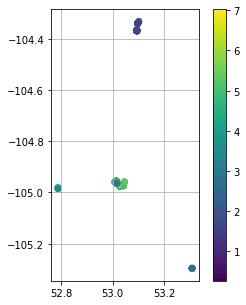

In [ ]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.long, df.lat))
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(5,5))
g_plot = gdf.plot(ax = ax, column='soc', legend = True)
plt.grid();

In [ ]:
index = 5
lat, long = df['lat'][index], df['long'][index]
date = df.date[index]
print('lat: ',lat, '\nlong: ', long)
size =  0.02 #111 km per degree
days = 90
cords = [[long-1.5*size, lat+size], [long-1.5*size, lat-size], 
         [long+1.5*size, lat-size], [long+1.5*size, lat+size]]
start, end = (date - timedelta(days=days)), (date + timedelta(days=days))
aoi = ee.Geometry.Polygon(cords, None, False) #order is longitude then latitude. 
print(start, date, end)
print(cords) # S@ start 23-06-15

lat:  42.40392563 
long:  -85.37921887
2021-01-28 00:00:00 2021-04-28 00:00:00 2021-07-27 00:00:00
[[-85.40921887, 42.42392563000001], [-85.40921887, 42.38392563], [-85.34921887, 42.38392563], [-85.34921887, 42.42392563000001]]


In [ ]:
df = df.sort_values(['lat','long'])
point = ee.Geometry.MultiPoint([[x,y] for x,y in zip(df['long'][:10000], df['lat'][:10000])])

sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR");
image = sentinel2.filterBounds(aoi) \
  .filterDate('2021-04-28', '2021-05-27') \
  .sort('CLOUDY_PIXEL_PERCENTAGE', False) \
  .mosaic() \
  .clip(aoi)

ndvi = image.normalizedDifference(['B3', 'B8']);

# Palettes for Visualization
trueColor_palette = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000};
waterPalette = ['green', 'yellow'];
swir = {'bands': ['B12'], 'min': 0, 'max': 6000};

Map = geemap.Map(zoom= 15)
Map.addLayer(ndvi, {'min': -0.45, 'max': 0.4, 'palette': waterPalette}, 'NDVI')
Map.addLayer(image, trueColor_palette, 'true color')
# Map.addLayer(image, swir, 'swir')
Map.addLayer(point,{'color': 'black'}, 'Geometry [black]: point')
Map.setCenter(long, lat)
Map

Map(center=[42.39319216, -85.38230309], controls=(WidgetControl(options=['position', 'transparent_bg'], widget…

In [ ]:
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.
vis_params = {'min': -1, 'max': 1,'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}
trueColor_palette = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000};
# Create a folium map object.
my_map = folium.Map(location=[lat, long], zoom_start=15)

# Add the elevation model to the map object.
my_map.add_ee_layer(ndvi, vis_params, 'DEM')
my_map.add_ee_layer(image, trueColor_palette, 'true color')
my_map.add_ee_layer(collectionVH, {'min': -15, 'max': 0,'palette': ['blue', 'green', 'yellow', 'orange',  'red']}, 'VV')
# my_map.add_ee_layer(point,{'color': 'black'},'Geometry [black]: point')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)